# Inference for SSD

Implementation according to run_ssd_example.py of SSD repository.

# Setup

Enable GPU acceleration in Google Colab!

In [1]:
!git clone https://github.com/qfgaohao/pytorch-ssd.git
%cd pytorch-ssd/

import torch

from IPython.display import Image, clear_output  # to display images
from google.colab.patches import cv2_imshow

clear_output()

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


## run once to load model

Inference time:  0.011817693710327148
tensor([[169.9641, 112.9760, 190.2879, 167.7850],
        [ 43.2270, 108.1102,  66.7274, 163.6740],
        [ 15.0644, 104.6290,  40.5446, 168.5645],
        [ 79.7818, 112.3064, 101.5443, 162.0434],
        [145.7026, 116.4865, 160.0163, 165.3948],
        [265.9301, 114.0135, 281.1070, 166.6671],
        [230.9725, 110.0280, 248.6192, 166.0416],
        [246.2496, 110.9058, 263.0417, 164.5837],
        [105.7743, 110.5394, 124.8004, 164.7176]])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([0.7463, 0.7295, 0.6373, 0.6078, 0.6043, 0.5529, 0.5103, 0.4768, 0.4764])


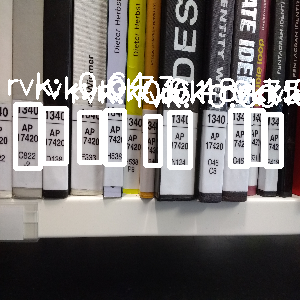

In [5]:
from vision.ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd, create_mobilenetv1_ssd_predictor
from vision.ssd.mobilenetv1_ssd_lite import create_mobilenetv1_ssd_lite, create_mobilenetv1_ssd_lite_predictor
from vision.ssd.squeezenet_ssd_lite import create_squeezenet_ssd_lite, create_squeezenet_ssd_lite_predictor
from vision.ssd.mobilenet_v2_ssd_lite import create_mobilenetv2_ssd_lite, create_mobilenetv2_ssd_lite_predictor
from vision.ssd.mobilenetv3_ssd_lite import create_mobilenetv3_large_ssd_lite, create_mobilenetv3_small_ssd_lite
from vision.utils.misc import Timer
import cv2
import sys
import time

import torchvision.transforms as transforms
from numpy import random
from google.colab.patches import cv2_imshow

label_path='path-to-lable-file' # path to file containing class label mapping according to VOC standard

# choose model
# uncomment respective model_path and net_type
# model_path needs to contain path to weights file of respective model architecture

# model_path='path-to-weight-file'
# net_type='mb1-ssd'

# model_path='path-to-weight-file'
# net_type='mb1-ssd-lite'

model_path='path-to-weight-file'
net_type='mb2-ssd-lite'

# model_path='path-to-weight-file'
# net_type='mb3-large-ssd-lite'

# model_path='path-to-weight-file'
# net_type='mb3-small-ssd-lite'

# model_path='path-to-weight-file'
# net_type='sq-ssd-lite'

class_names = [name.strip() for name in open(label_path).readlines()]

if net_type == 'vgg16-ssd':
    net = create_vgg_ssd(len(class_names), is_test=True)
elif net_type == 'mb1-ssd':
    net = create_mobilenetv1_ssd(len(class_names), is_test=True)
elif net_type == 'mb1-ssd-lite':
    net = create_mobilenetv1_ssd_lite(len(class_names), is_test=True)
elif net_type == 'mb2-ssd-lite':
    net = create_mobilenetv2_ssd_lite(len(class_names), is_test=True)
elif net_type == 'mb3-large-ssd-lite':
    net = create_mobilenetv3_large_ssd_lite(len(class_names), is_test=True)
elif net_type == 'mb3-small-ssd-lite':
    net = create_mobilenetv3_small_ssd_lite(len(class_names), is_test=True)
elif net_type == 'sq-ssd-lite':
    net = create_squeezenet_ssd_lite(len(class_names), is_test=True)
else:
    print('The net type is wrong. It should be one of vgg16-ssd, mb1-ssd and mb1-ssd-lite.')
    sys.exit(1)
    
net.load(model_path)

if net_type == 'vgg16-ssd':
    predictor = create_vgg_ssd_predictor(net, candidate_size=200, device=0)
elif net_type == 'mb1-ssd':
    predictor = create_mobilenetv1_ssd_predictor(net, candidate_size=200, device=0)
elif net_type == 'mb1-ssd-lite':
    predictor = create_mobilenetv1_ssd_lite_predictor(net, candidate_size=200, device=0)
elif net_type == 'mb2-ssd-lite' or net_type == 'mb3-large-ssd-lite' or net_type == 'mb3-small-ssd-lite':
    predictor = create_mobilenetv2_ssd_lite_predictor(net, candidate_size=200, device=0)
elif net_type == 'sq-ssd-lite':
    predictor = create_squeezenet_ssd_lite_predictor(net, candidate_size=200, device=0)
else:
    predictor = create_vgg_ssd_predictor(net, candidate_size=200, device=0)

# variables
path = 'path-to-image' # path to image for initial inference
imgsz = 300 # image size
conf_thres = 0.4 # confidence

colors = [[random.randint(0, 255) for _ in range(3)] for _ in class_names]

img1 = cv2.imread(path)
img0 = cv2.resize(img1, (imgsz, imgsz))

# scaling factors for x and y respective to original input size and chosen imgsz for prediction
scaley = img1.shape[0]/imgsz
scalex = img1.shape[1]/imgsz

boxes, labels, probs = predictor.predict(img0, prob_threshold=conf_thres)

print(boxes)
print(labels)
print(probs)
# draw boxes
for i in range(boxes.size(0)):
    if probs[i] > 0.1:
        box = boxes[i, :]
        cv2.rectangle(img0, (box[0], box[1]), (box[2], box[3]), (255, 255, 255), 4)
        label = f'{class_names[labels[i]]}: {probs[i]:.2f}'
        cv2.putText(img0, label,
                    (box[0] - 10, box[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,  # font scale
                    (255, 255, 255),
                    2)  # line type
  
cv2_imshow(img0)

In [3]:
def detect(path):
    img1 = cv2.imread(path)
    img0 = cv2.resize(img1, (imgsz, imgsz))

    # scaling factors for x and y respective to original input size and chosen imgsz for prediction
    scaley = img1.shape[0]/imgsz
    scalex = img1.shape[1]/imgsz

    boxes, labels, probs = predictor.predict(img0, prob_threshold=conf_thres)

    return boxes, labels, probs, img0

# Inference on folder


In [ ]:
import os

directory = 'path-to-inference-folder'

for filename in os.listdir(directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        
        path = os.path.join(directory, filename)

        boxes, labels, probs, img = detect(path)

        for i in range(boxes.size(0)):
            if probs[i] > 0.1:
                box = boxes[i, :]
                cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 255, 255), 4)
                label = f'{class_names[labels[i]]}: {probs[i]:.2f}'
                cv2.putText(img, label,
                            (box[0] - 10, box[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1,  # font scale
                            (255, 255, 255),
                            2)  # line type
  
        cv2_imshow(img)